# Notebook: Prédiction d'annulations des réservations du dataset Hotel Reservations

### Emilian Loric et Loucas Cubeddu IS4

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Nettoyage et catégorisation le type de chaque variable

In [3]:
#data = pd.read_csv("/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv")

data = pd.read_csv("Hotel Reservations.csv")

continuous = ['lead_time', 'avg_price_per_room']

categorical = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 
               'repeated_guest', 'required_car_parking_space']

discrete = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
            'no_of_week_nights', 'arrival_year', 'arrival_month', 
            'arrival_date', 'no_of_previous_cancellations',
            'no_of_previous_bookings_not_canceled',
            'no_of_special_requests']

data.drop("Booking_ID", inplace=True, axis=1)

for column in ["booking_status"] + categorical:
    data[column] = data[column].astype("category")
    
data_clean = data.drop(["arrival_year", "arrival_date"], axis=1)
data_clean = data_clean.rename({"arrival_month": "month"}, axis=1)

continuous_clean = [c for c in continuous if c in data_clean.columns]
discrete_clean = [d for d in discrete if d in data_clean.columns]
categorical_clean = [c for c in categorical if c in data_clean.columns]

## Encodage du label à prédire

In [28]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

label_encoder = LabelEncoder()

data_clean_encoded = data_clean.copy()

for var in categorical_clean:
    data_clean_encoded[var] = label_encoder.fit_transform(data_clean_encoded[var])

data_clean_encoded["booking_status"] = data_clean_encoded["booking_status"].replace("Canceled", 1)
data_clean_encoded["booking_status"] = data_clean_encoded["booking_status"].replace("Not_Canceled", 0)

In [29]:
data_clean_encoded["booking_status"]

0        0
1        0
2        1
3        1
4        1
        ..
36270    0
36271    1
36272    0
36273    1
36274    0
Name: booking_status, Length: 36275, dtype: category
Categories (2, int64): [1, 0]

In [30]:
data["booking_status"]

0        Not_Canceled
1        Not_Canceled
2            Canceled
3            Canceled
4            Canceled
             ...     
36270    Not_Canceled
36271        Canceled
36272    Not_Canceled
36273        Canceled
36274    Not_Canceled
Name: booking_status, Length: 36275, dtype: category
Categories (2, object): ['Canceled', 'Not_Canceled']

## Modèle de prédiction d’annulation des réservations

In [31]:
#pip install xgboost

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load data
X, y = (data_clean_encoded[continuous_clean + discrete_clean + categorical_clean],
        data_clean_encoded[["booking_status"]])
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y = np.ravel(y)

pca_preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), continuous_clean + discrete_clean),
        ('pca', PCA(), continuous_clean + discrete_clean)
])

scaler_preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), continuous_clean + discrete_clean)
])

# Create a pipeline with normalization (optional) and classifier
pipe = Pipeline([
    ('preprocessor', pca_preprocessor),
    ('clf', SVC())
])

param_grid = [
#    {'clf': [SVC()], 'clf__C': [5, 10, 20], 'clf__kernel': ['polynomial', 'rbf']},
    {"preprocessor": [pca_preprocessor, scaler_preprocessor], 'clf': [RandomForestClassifier()], 'clf__n_estimators': [10, 50, 100], 'clf__max_depth': [5, 10]},
    {"preprocessor": [pca_preprocessor, scaler_preprocessor], 'clf': [XGBClassifier()], 'clf__n_estimators': [10, 50, 100], 'clf__max_depth': [5, 10]},
    {"preprocessor": [pca_preprocessor, scaler_preprocessor], 'clf': [LogisticRegression()], 'clf__C': [5, 10, 20]}
]

single_param = [
    {'clf': [SVC()], 'clf__C': [10], 'clf__kernel': ['rbf']}
    #{'clf': [LogisticRegression()], 'clf__C': [0.1, 1, 10]}
]

# Cross-validation
cv = StratifiedKFold(n_splits=5)


# Perform grid search with 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring="f1")
grid.fit(X, y)

C:\Users\emili\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\emili\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['lead_time',
                                                                          'avg_price_per_room',
                                                                          'no_of_adults',
                                                                          'no_of_children',
                                                                          'no_of_weekend_nights',
                                                                          'no_of_week_nights',
                                                                          'no_of_previous_cancellations',
                            

In [175]:
#import joblib

# Save the grid search object to a file
#joblib.dump(grid, '/kaggle/working/gridsearch_full.pkl')

['/kaggle/working/gridsearch_full.pkl']

In [ ]:
# Load the grid search object from the file
#grid = joblib.load('/kaggle/working/gridsearch_full.pkl')

In [33]:
print(grid.best_params_)

{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), 'clf__max_depth': 10, 'clf__n_estimators': 100, 'preprocessor': ColumnTransformer(transformers=[('scale', StandardScaler(),
                                 ['lead_time', 'avg_price_per_room',
                                  'no_of_adults'

In [41]:
results = grid.cv_results_

# Display the test score for each model
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"test score: {mean_score:.3f} for {params}")

test score: 0.651 for {'clf': RandomForestClassifier(), 'clf__max_depth': 5, 'clf__n_estimators': 10, 'preprocessor': ColumnTransformer(transformers=[('scale', StandardScaler(),
                                 ['lead_time', 'avg_price_per_room',
                                  'no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
                                  'no_of_special_requests']),
                                ('pca', PCA(),
                                 ['lead_time', 'avg_price_per_room',
                                  'no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
 

In [42]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, classification_report

def get_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    return {'f1': f1,
            'accuracy': acc,
            'recall': rec,
            'precision': prec,
            'auc': auc,
            'FP': fp,
            'FN': fn,
            'TP': tp,
            'TN': tn}


In [43]:
y_pred = grid.predict(X)

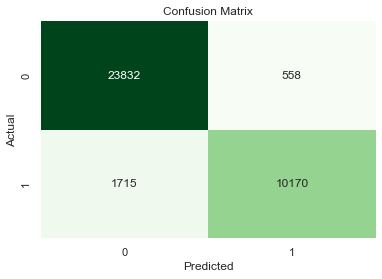

In [44]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)

# Affichage de la matrice de confusion avec Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
get_metrics(y, y_pred)

{'f1': 0.8994825985052844,
 'accuracy': 0.9373397656788421,
 'recall': 0.8557004627681952,
 'precision': 0.947986577181208,
 'auc': 0.9164111169929537,
 'FP': 558,
 'FN': 1715,
 'TP': 10170,
 'TN': 23832}

## Graphique sur l'importance des variables issues de Gradient Boosting

In [16]:
grid.best_estimator_.named_steps["clf"].feature_importances_

array([0.13630506, 0.09018079, 0.12224788, 0.05279376, 0.06148244,
       0.05146625, 0.048196  , 0.17541087, 0.26191697], dtype=float32)

In [17]:
X.columns

Index(['lead_time', 'avg_price_per_room', 'no_of_adults', 'no_of_children',
       'no_of_weekend_nights', 'no_of_week_nights',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'no_of_special_requests', 'type_of_meal_plan', 'room_type_reserved',
       'market_segment_type', 'repeated_guest', 'required_car_parking_space'],
      dtype='object')

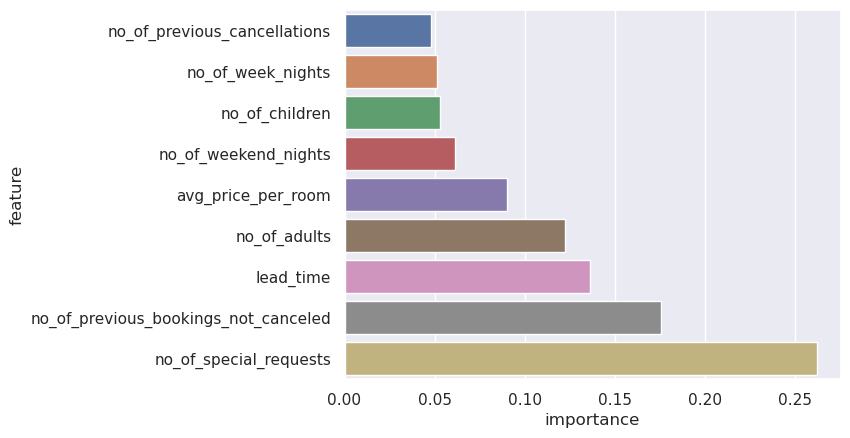

In [198]:
import seaborn as sns
sns.set_theme()

# Get the feature importance scores
feature_importance = grid.best_estimator_.named_steps["clf"].feature_importances_

order = np.argsort(feature_importance)
feature_importance = [feature_importance[i] for i in order]
importance_columns = [X.columns[i] for i in order]

importance_df = pd.DataFrame({'feature': importance_columns, 'importance': feature_importance})

# Create a bar plot of feature importance
sns.barplot(x='importance', y='feature', data=importance_df);

## Modèle de prédiction d’annulation des réservation “online”

In [45]:
data_clean_encoded_online = data_clean_encoded[data["market_segment_type"] == "Online"]
X, y = (data_clean_encoded_online[continuous_clean + discrete_clean + categorical_clean],
        data_clean_encoded_online[["booking_status"]])

y = np.ravel(y)
data_clean_encoded_online

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,month,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
1,2,0,2,3,3,0,0,5,11,4,0,0,0,106.68,1,0
2,1,0,2,1,0,0,0,1,2,4,0,0,0,60.00,0,1
3,2,0,0,2,0,0,0,211,5,4,0,0,0,100.00,0,1
4,2,0,1,1,3,0,0,48,4,4,0,0,0,94.50,0,1
5,2,0,0,2,1,0,0,346,9,4,0,0,0,115.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36269,2,2,0,1,0,0,5,0,10,4,0,0,0,216.00,0,1
36270,3,0,2,6,0,0,3,85,8,4,0,0,0,167.80,1,0
36271,2,0,1,3,0,0,0,228,10,4,0,0,0,90.95,2,1
36272,2,0,2,6,0,0,0,148,7,4,0,0,0,98.39,2,0


In [46]:

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y = np.ravel(y)

pca_preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), continuous_clean + discrete_clean),
        ('pca', PCA(), continuous_clean + discrete_clean)
])

scaler_preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), continuous_clean + discrete_clean)
])

# Create a pipeline with normalization (optional) and classifier
pipe = Pipeline([
    ('preprocessor', pca_preprocessor),
    ('clf', SVC())
])

param_grid = [
#    {'clf': [SVC()], 'clf__C': [5, 10, 20], 'clf__kernel': ['polynomial', 'rbf']},
    {"preprocessor": [pca_preprocessor, scaler_preprocessor], 'clf': [RandomForestClassifier()], 'clf__n_estimators': [10, 50, 100], 'clf__max_depth': [5, 10]},
    {"preprocessor": [pca_preprocessor, scaler_preprocessor], 'clf': [XGBClassifier()], 'clf__n_estimators': [10, 50, 100], 'clf__max_depth': [5, 10]},
    {"preprocessor": [pca_preprocessor, scaler_preprocessor], 'clf': [LogisticRegression()], 'clf__C': [5, 10, 20]}
]

single_param = [
    {'clf': [SVC()], 'clf__C': [10], 'clf__kernel': ['rbf']}
    #{'clf': [LogisticRegression()], 'clf__C': [0.1, 1, 10]}
]

# Cross-validation
cv = StratifiedKFold(n_splits=5)


# Perform grid search with 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring="f1")
grid.fit(X, y)

C:\Users\emili\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\emili\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['lead_time',
                                                                          'avg_price_per_room',
                                                                          'no_of_adults',
                                                                          'no_of_children',
                                                                          'no_of_weekend_nights',
                                                                          'no_of_week_nights',
                                                                          'no_of_previous_cancellations',
                            

In [50]:
y_pred = grid.predict(X)

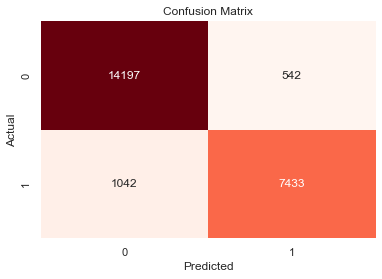

In [51]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)

# Affichage de la matrice de confusion avec Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [52]:
get_metrics(y, y_pred)

{'f1': 0.90370820668693,
 'accuracy': 0.9317653140346343,
 'recall': 0.8770501474926253,
 'precision': 0.9320376175548589,
 'auc': 0.9201384803546309,
 'FP': 542,
 'FN': 1042,
 'TP': 7433,
 'TN': 14197}

## Analyse des variables du modèle d’annulation des réservation “online

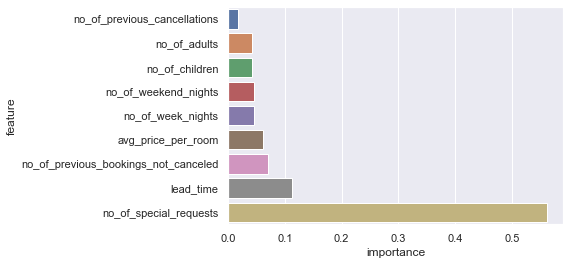

In [23]:
import seaborn as sns
sns.set_theme()

# Get the feature importance scores
feature_importance = grid.best_estimator_.named_steps["clf"].feature_importances_

order = np.argsort(feature_importance)
feature_importance = [feature_importance[i] for i in order]
importance_columns = [X.columns[i] for i in order]

importance_df = pd.DataFrame({'feature': importance_columns, 'importance': feature_importance})

# Create a bar plot of feature importance
sns.barplot(x='importance', y='feature', data=importance_df);
